# Time Series EDA

## Imports and Data Loading

### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from scipy.stats import f
import ruptures as rpt

# Default charting
rcParams['figure.figsize'] = 12,8
sns.set_theme()

### Load Data

In [2]:
# Read in Data
df = pd.read_csv('./data/LD2011_2014.txt', sep=';', decimal=',')
df = df.loc[:,['Unnamed: 0', 'MT_001']]

# Fix unnamed column
df.rename(columns={'Unnamed: 0': 'electricity_timestamp'}, inplace=True)

# Fix timestamp format
df['electricity_timestamp'] = pd.to_datetime(df['electricity_timestamp'])

# Upsample to the day level
df = df.resample('1D', on='electricity_timestamp').sum().reset_index()
df = df.loc[(df['electricity_timestamp'] >= '2012-01-01') & (df['electricity_timestamp'] < '2015-01-01'), :]

# Unpivot data
df = pd.melt(df, id_vars='electricity_timestamp', value_vars=df.columns[df.columns.str.contains('MT_')])
df.rename(columns={'variable': 'customer_id', 'value': 'consumption_kw'}, inplace=True)

### Visualize Sample

In [3]:
df.tail()

,electricity_timestamp,customer_id,consumption_kw
1091,2014-12-27,MT_001,211.928934
1092,2014-12-28,MT_001,227.157360
1093,2014-12-29,MT_001,248.730964
1094,2014-12-30,MT_001,232.233503
1095,2014-12-31,MT_001,229.695431


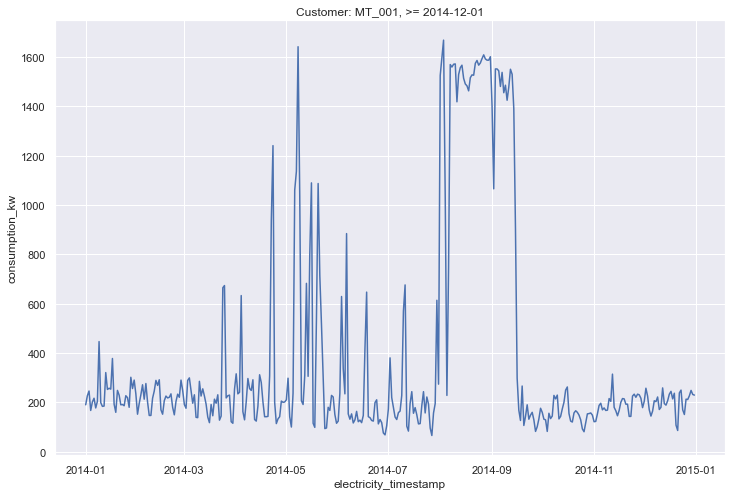

In [4]:
# Plot one example
ax = sns.lineplot(data=df.loc[(df.electricity_timestamp>='2014-01-01'), :], x='electricity_timestamp', y='consumption_kw')
ax.set_title('Customer: MT_001, >= 2014-12-01')
plt.show()

In [5]:
# Clean up to just time series and datetime index
df_ts = df.loc[:, ['electricity_timestamp', 'consumption_kw']].copy()
df_ts.sort_values('electricity_timestamp', inplace=True)
df_ts.set_index('electricity_timestamp', inplace=True)

## EDA

### Stationary

In [6]:
adf_result = adfuller(df_ts)
print(f'ADF Test Statistic {adf_result[0]:.2f}')
print(f'P Value {adf_result[1]:.2f}')
if adf_result[1] > 0.05:
    print('Time series is not stationary. Time-dependent structure such as seasonality exists.')
else:
    print('Time series is stationary, p value < 0.05.')

ADF Test Statistic -3.91
P Value 0.00
Time series is stationary, p value < 0.05.


### Seasonality
Time series is already stationary, but showing just for demonstration purposes.

In [7]:
sd = seasonal_decompose(df_ts)

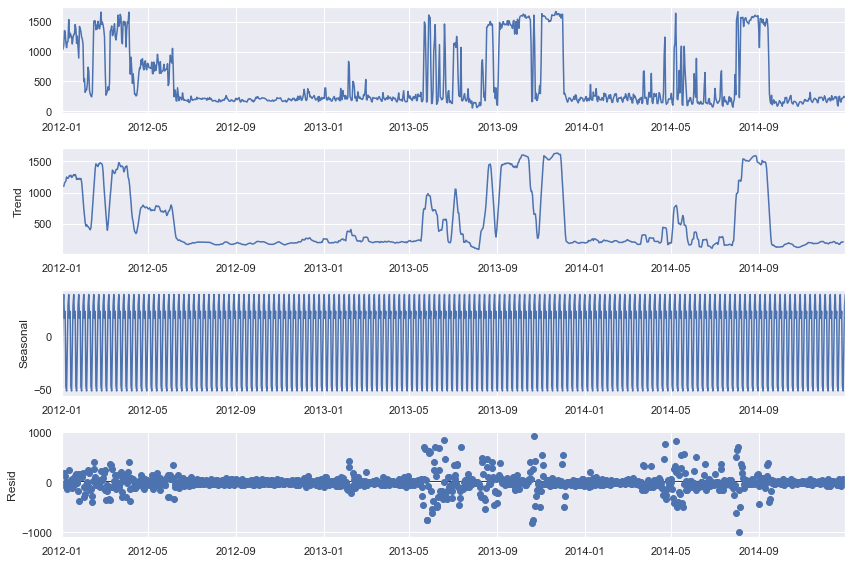

In [8]:
sd.plot()
plt.show()

### Autocorrelation

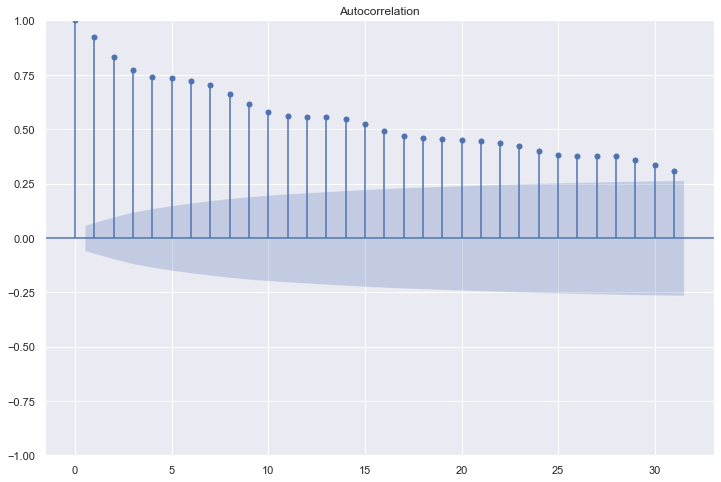

In [9]:
plot_acf(df_ts)
plt.show()

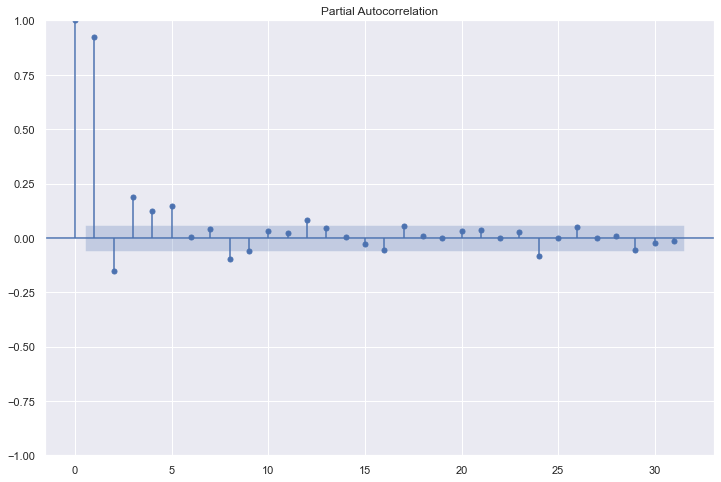

In [10]:
plot_pacf(df_ts, method='ywm')
plt.show()

### Structural Breaks

#### Create Days column for regression fit

In [11]:
df['days'] = (df['electricity_timestamp'] - np.min(df['electricity_timestamp'])).dt.days
df.head()

,electricity_timestamp,customer_id,consumption_kw,days
0,2012-01-01,MT_001,711.928934,0
1,2012-01-02,MT_001,1025.380711,1
2,2012-01-03,MT_001,1040.609137,2
3,2012-01-04,MT_001,1093.908629,3
4,2012-01-05,MT_001,1351.522843,4


#### Manual Version Using Chow Test

In [12]:
def parse_df(df_parse: pd.DataFrame, x_col_names: list[str], y_col_name: str):
    y = df_parse.loc[:, y_col_name]
    x = df_parse.loc[:, x_col_names]
    deg_freedom_x = x.shape[1] + 1
    return x, y, deg_freedom_x


def ols_ssr(x, y):
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    return model.ssr


def chow_test(df_full: pd.DataFrame, df_a: pd.DataFrame, df_b: pd.DataFrame, x_col_names: list[str], y_col_name: str):
    
    # Parse full df into x, y
    df_full_x, df_full_y, deg_freedom_full = parse_df(df_full, x_col_names, y_col_name)
    df_a_x, df_a_y, deg_freedom_a = parse_df(df_a, x_col_names, y_col_name)
    df_b_x, df_b_y, deg_freedom_b = parse_df(df_b, x_col_names, y_col_name)

    # Grab k, representing number of variables in regression
    assert deg_freedom_full == deg_freedom_a == deg_freedom_b, 'Number of covariates do not match.'
    k = deg_freedom_full

    # Get N from each dataset
    n_full = df_full.shape[0]
    n_a = df_a.shape[0]
    n_b = df_b.shape[0]
    assert n_full == n_a + n_b, 'Length of individual series must equal full series.'

    # Calc F degrees of freedom
    deg_freedom_f = n_a + n_b - 2*k

    # Calc all model ssrs
    ssr_total = ols_ssr(df_full_x, df_full_y)
    ssr_a = ols_ssr(df_a_x, df_a_y)
    ssr_b = ols_ssr(df_b_x, df_b_y)
    combined_parts_ssr = ssr_a + ssr_b

    # Calc chow statistic
    chow_statistic_numerator = ((ssr_total - combined_parts_ssr)/float(k))
    chow_statistic_denominator = combined_parts_ssr/float(deg_freedom_f)
    chow_statistic = chow_statistic_numerator / chow_statistic_denominator
    p_value = 1 - f.cdf(chow_statistic, k, deg_freedom_f)
    return (chow_statistic, p_value)


def dynamic_chow_test_single_pass(df_full: pd.DataFrame, min_window_size: int, x_col_names: list[str], y_col_name: str, alpha: float = 0.05):

    # Determine length and start/end of running test
    n = len(df_full)
    if len(df_full) < (min_window_size * 2.0):
        return None
    start_int = min_window_size
    end_int = n - min_window_size

    # Loop through possible break points
    potential_break_points = []
    for i in range(start_int, end_int+1):
        chow_stat, p_value = chow_test(df_full, df_full.iloc[:i,:], df_full.iloc[i:,:], x_col_names, y_col_name)
        potential_break_points.append((i,p_value))

    # Sort to find best break point
    df_break_points = pd.DataFrame(potential_break_points)
    df_break_points.columns = ['break_point', 'p_value']
    best_break_point = int(df_break_points.sort_values(by='p_value', ascending=True).iloc[0]['break_point'])
    best_break_point_p_value = int(df_break_points.sort_values(by='p_value', ascending=True).iloc[0]['p_value'])

    if best_break_point_p_value <= alpha:
        return best_break_point
    else:
        return None

def recursive_break_points(df_full: pd.DataFrame, min_window_size: int, x_col_names: list[str], y_col_name: str, alpha: float = 0.05, break_points: list = []):
    break_point = dynamic_chow_test_single_pass(df_full, min_window_size, x_col_names, y_col_name, alpha)
    if break_point:
        break_points.extend(df_full.iloc[break_point])
        recursive_break_points(df_full.iloc[:break_point, :], min_window_size, x_col_names, y_col_name, alpha, break_points)
        recursive_break_points(df_full.iloc[break_point:, :], min_window_size, x_col_names, y_col_name, alpha, break_points)
    return break_points


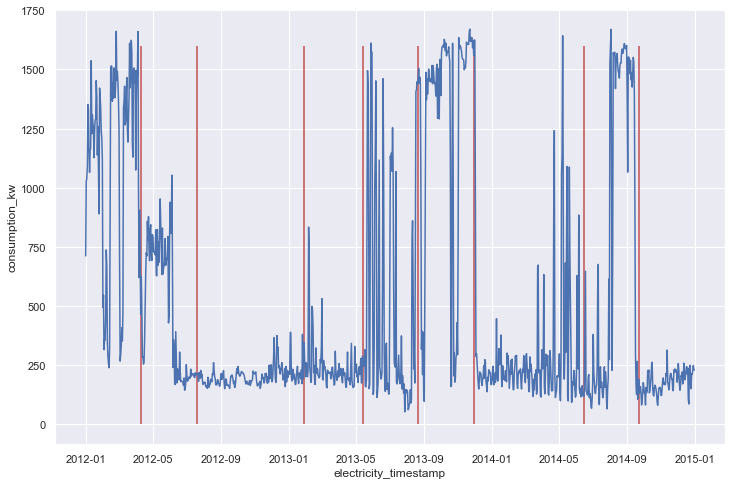

In [13]:
# Run recursive search
break_points = []
break_points = recursive_break_points(df, 100, ['days'], 'consumption_kw', alpha = 0.01)

# Parse Results
break_point_timestamps = [break_point for break_point in break_points if isinstance(break_point, pd.Timestamp)]
df_breakpoints = pd.DataFrame(break_point_timestamps)
df_breakpoints.columns = ['break_point_timestamp']

# Plot Results
ax = sns.lineplot(data=df, x='electricity_timestamp', y='consumption_kw')
plt.vlines(df_breakpoints['break_point_timestamp'], 0, 1600, colors='r')
plt.show()

#### Change Point Detection Using Ruptures Library

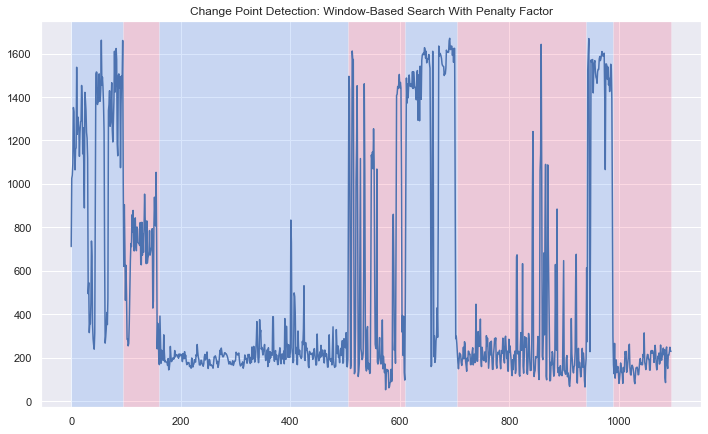

In [17]:
# Model Inputs
points = np.array(df.consumption_kw)
model = "l2"

# Define and fit model (window with 90 width and l2 loss)
algo = rpt.Window(width=90, model=model).fit(points)

# Predict breakpoints - either manually or via penalization factor
# breakpoints = algo.predict(n_bkps=10) # or define number of break points manually
breakpoints = algo.predict(pen=np.log(len(points)) * 2 * np.var(points)/2)

# Display results
rpt.show.display(points, breakpoints, figsize=(10, 6))
plt.title('Change Point Detection: Window-Based Search With Penalty Factor')
plt.show()

In [18]:
breakpoints

[95, 160, 505, 610, 705, 940, 990, 1096]